### kaggle 집값 예측 문제

columns

- `house_id` - 주택 id변수
- `date` - 판매된 날자
- `location` - 주택 위치
- `type` - 주택 유형 ("2 ROOM", "3 ROOM", "4 ROOM", "5 ROOM", "EXECUTIVE")
- `block` - 주택이 위치한 블록
- `street` - 주택이 위치한 거리
- `storey_range` - 주택이 위치한 층 범위
- `area_sqm	` - 주택의 면적
- `flat_model` - 주택의 모델(구조, 방 배치 등)
- `commence_date` - 주택이 판매에 올라온 날짜
- `price` - 판매 가격 (목표 변수)

additional columns

- `type_num` - 방의 개수
- `area_per_room` - 방 하나당 평균 면적
- `adress` - 주소
- `Year` - 판매 연도
- `Month` - 판매 월
- `time_to_sell` - 판매까지 걸린 연도
- `interest_rate` - 집이 팔린 당시의 금리

delete columns
- `price_per_unitarea` - 단위면적(1m^2)당 가격
- `price_per_room` - 방하나당 평균 가격

다양한 변수를 사용하여 짒값을 예측한다

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.preprocessing import LabelEncoder

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import  cross_val_score

import seaborn as sns
import gc

In [2]:
# 데이터 불러오기
try:
    data = pd.read_csv('data/test.csv',encoding='utf-8')
    train = pd.read_csv('data/train.csv',encoding='utf-8')
except UnicodeDecodeError:
    # UTF-8로 실패할 경우 CP949로 재시도
    data = pd.read_csv('data/test.csv',encoding='cp949-8')
    train = pd.read_csv('data/train.csv',encoding='cp949')

In [3]:
data.tail()

,house_id,date,location,type,block,street,storey_range,area_sqm,flat_model,commence_date
67925,339632,2012-02,Riverside,4 ROOM,610,Northpark Dr,04 TO 06,84.0,N,1986
67926,339639,2012-02,Riverside,5 ROOM,796,Laredo Rd,04 TO 06,123.0,D,1987
67927,339642,2012-02,Riverside,5 ROOM,855,Laredo Rd,04 TO 06,127.0,D,1988
67928,339643,2012-02,Riverside,5 ROOM,366,Laredo Rd,07 TO 09,122.0,D,1988
67929,339644,2012-02,Riverside,5 ROOM,115B,Laredo Rd,16 TO 18,111.0,D,2001


In [4]:
train.tail()

,house_id,date,location,type,block,street,storey_range,area_sqm,flat_model,commence_date,price
271716,101563,2003-01,Omaha,4 ROOM,483,Sandra Ln,04 TO 06,103.0,G,1989,232000.0
271717,28297,2000-11,Omaha,5 ROOM,615,Atkin Rd,10 TO 12,134.0,G,1996,428000.0
271718,321995,2011-04,Boston,5 ROOM,390,Kempton Street,13 TO 15,118.0,D,2004,548888.0
271719,308162,2010-09,Fresno,4 ROOM,968,Magnolia Dale Dr,13 TO 15,90.0,I,1999,360000.0
271720,225691,2007-10,Milwaukee,EXECUTIVE,341,W Fond du Lac Avenue,04 TO 06,143.0,C,1993,450000.0


### EDA

In [5]:
#기초 통계량 확인
train.describe()

,house_id,area_sqm,commence_date,price
count,271721.000000,271721.000000,271721.000000,271721.000000
mean,169785.994870,96.544832,1987.982942,281197.589537
std,98022.533902,25.587877,9.125141,112160.993184
min,1.000000,28.000000,1966.000000,28000.000000
25%,85021.000000,73.000000,1981.000000,195000.000000
50%,169739.000000,99.000000,1987.000000,263000.000000
75%,254609.000000,115.000000,1997.000000,350000.000000
max,339651.000000,280.000000,2010.000000,903000.000000


In [6]:
#결측치 확인, 결측치 없음
train.isna().sum()

house_id         0
date             0
location         0
type             0
block            0
street           0
storey_range     0
area_sqm         0
flat_model       0
commence_date    0
price            0
dtype: int64

In [7]:
train['type'].value_counts()

4 ROOM              104589
3 ROOM               84422
5 ROOM               59817
EXECUTIVE            19903
2 ROOM                2602
1 ROOM                 265
MULTI-GENERATION       123
Name: type, dtype: int64

In [8]:
train['type']

0            5 ROOM
1            3 ROOM
2            4 ROOM
3            4 ROOM
4            4 ROOM
            ...    
271716       4 ROOM
271717       5 ROOM
271718       5 ROOM
271719       4 ROOM
271720    EXECUTIVE
Name: type, Length: 271721, dtype: object

In [9]:
# 방의 타입에 따른 방개수 생성
# EXECUTIVE, MULTI-GENERATION는 결측치로 변경
tmp = []
for i in train['type']:
    if i == '5 ROOM':
        tmp.append(5)
    elif i == '4 ROOM':
        tmp.append(4)
    elif i == '3 ROOM':
        tmp.append(3)
    elif i == '2 ROOM':
        tmp.append(2)
    elif i == '1 ROOM':
        tmp.append(1)
    elif i == 'EXECUTIVE':
        tmp.append(None)
    else :
        tmp.append(None)
    
train['type_num'] = tmp


In [10]:
# 결측치 확인
train['type_num'].isna().sum()

20026

In [11]:
# 방개수 결측치 중앙값으로
tmp = []

tmp = train['type_num'].fillna(train['type_num'].median())
train['type_num'] = tmp
train['type_num']

0         5.0
1         3.0
2         4.0
3         4.0
4         4.0
         ... 
271716    4.0
271717    5.0
271718    5.0
271719    4.0
271720    4.0
Name: type_num, Length: 271721, dtype: float64

In [12]:
# 방개수에 따른 방하나 평균 면적(m^2)
tmp = []
for num_rooms, area_sqm in zip(train['type_num'], train['area_sqm']):
    tmp.append(round(area_sqm/num_rooms, 3))
train['area_per_room'] = tmp

In [13]:
# 단위면적(1m^2)당 가격
# tmp = []
# for price, area in zip(train['price'], train['area_sqm']):
#     tmp.append( round(price/area, 3) )
# train['price_per_unitarea'] = tmp

In [14]:
# 방개수에 따른 방하나 평균 가격
# tmp = []
# for price, num_rooms in zip(train['price'], train['type_num']):
#     tmp.append( round(num_rooms/price, 3) )
# train['price_per_room'] = tmp

In [15]:
# 지역과 블록을 합쳐 주소와 상세주소만 남긴다.
train['adress'] = train['location'] + '/' + train['block']
train.drop('location', axis=1, inplace=True)
train.drop('block', axis=1, inplace=True)
train

,house_id,date,type,street,storey_range,area_sqm,flat_model,commence_date,price,type_num,area_per_room,adress
0,199577,2006-09,5 ROOM,Agawan Court,07 TO 09,110.0,D,2003,313000.0,5.0,22.000,Raleigh/107D
1,217021,2007-06,3 ROOM,Cleo St,07 TO 09,64.0,N,1988,167000.0,3.0,21.333,Fresno/678
2,308062,2010-09,4 ROOM,E Pleasant View Way,10 TO 12,92.0,K,1976,430000.0,4.0,23.000,Tucson/5
3,212465,2007-04,4 ROOM,Park Hollow Ln,10 TO 12,92.0,K,1977,303800.0,4.0,23.000,Austin/326
4,60654,2001-10,4 ROOM,Ala Puawa Place,04 TO 06,102.0,G,1998,212000.0,4.0,25.500,Honolulu/794
...,...,...,...,...,...,...,...,...,...,...,...,...
271716,101563,2003-01,4 ROOM,Sandra Ln,04 TO 06,103.0,G,1989,232000.0,4.0,25.750,Omaha/483
271717,28297,2000-11,5 ROOM,Atkin Rd,10 TO 12,134.0,G,1996,428000.0,5.0,26.800,Omaha/615
271718,321995,2011-04,5 ROOM,Kempton Street,13 TO 15,118.0,D,2004,548888.0,5.0,23.600,Boston/390
271719,308162,2010-09,4 ROOM,Magnolia Dale Dr,13 TO 15,90.0,I,1999,360000.0,4.0,22.500,Fresno/968


In [16]:
# 'date' 컬럼을 datetime 타입으로 변환하고, 연, 월 로 분리
tmp = {}
tmp['date'] = pd.to_datetime(train['date'])
train['Year'] = tmp['date'].dt.year
train['Month'] = tmp['date'].dt.month


In [17]:
train.drop('date', axis=1, inplace=True)

In [18]:
#팔리기까지의 기간
tmp_list = []

for i, j in zip(train['commence_date'], train['Year']):
    tmp_list.append(j-i)

train['time_to_sell'] = tmp_list

In [19]:
#  2000~2012년의 미국 금리 데이터를 가져옴
interest_rate_df = pd.read_csv('./data/interest_rate.csv')
interest_rate_df

,interest_rate_date,interest_rate
0,2012-12-13,0.25
1,2012-10-25,0.25
2,2012-09-14,0.25
3,2012-08-02,0.25
4,2012-06-21,0.25
...,...,...
73,2001-02-01,5.50
74,2001-01-04,6.00
75,2000-05-17,6.50
76,2000-03-22,6.00


In [20]:
# 날자 데이터를 비교하여 당일의 금리를 확인하여 저장

tmp = interest_rate_df['interest_rate'][77]
tmp_interest_rate = []

for year, month in zip(train['Year'], train['Month']):
    date = str(year) + '-' + str(month)
    # print(pd.Timestamp(date))
    
    for interest_date, interest_rate in zip(interest_rate_df['interest_rate_date'][::-1], interest_rate_df['interest_rate'][::-1]):
        if pd.Timestamp(date) < pd.Timestamp(interest_date):
            # 금리 갱신일 이 날자보다 커지면 그 이전 날의 금리(tmp)를 저장
            tmp_interest_rate.append(tmp)
            tmp = interest_rate_df['interest_rate'][77]
            break
        # 금리 갱신일이 당일 날자보다 낮다면 해당의 금리로 tmp를 갱신
        tmp = interest_rate

In [21]:
# 생성한 리스트를 dataframe에 합침
train['interest_rate'] = tmp_interest_rate

In [22]:
train

,house_id,type,street,storey_range,area_sqm,flat_model,commence_date,price,type_num,area_per_room,adress,Year,Month,time_to_sell,interest_rate
0,199577,5 ROOM,Agawan Court,07 TO 09,110.0,D,2003,313000.0,5.0,22.000,Raleigh/107D,2006,9,3,5.25
1,217021,3 ROOM,Cleo St,07 TO 09,64.0,N,1988,167000.0,3.0,21.333,Fresno/678,2007,6,19,5.25
2,308062,4 ROOM,E Pleasant View Way,10 TO 12,92.0,K,1976,430000.0,4.0,23.000,Tucson/5,2010,9,34,0.25
3,212465,4 ROOM,Park Hollow Ln,10 TO 12,92.0,K,1977,303800.0,4.0,23.000,Austin/326,2007,4,30,5.25
4,60654,4 ROOM,Ala Puawa Place,04 TO 06,102.0,G,1998,212000.0,4.0,25.500,Honolulu/794,2001,10,3,3.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271716,101563,4 ROOM,Sandra Ln,04 TO 06,103.0,G,1989,232000.0,4.0,25.750,Omaha/483,2003,1,14,1.25
271717,28297,5 ROOM,Atkin Rd,10 TO 12,134.0,G,1996,428000.0,5.0,26.800,Omaha/615,2000,11,4,6.50
271718,321995,5 ROOM,Kempton Street,13 TO 15,118.0,D,2004,548888.0,5.0,23.600,Boston/390,2011,4,7,0.25
271719,308162,4 ROOM,Magnolia Dale Dr,13 TO 15,90.0,I,1999,360000.0,4.0,22.500,Fresno/968,2010,9,11,0.25


In [23]:
#정규화
categorical_features = ['type', 'street', 'storey_range', 'flat_model', 'commence_date', 'adress', 'Year', 'Month']

le = LabelEncoder()
for i in categorical_features:
    train[i] = le.fit_transform(train[i])

In [24]:
numerical_features = ['area_sqm', 'time_to_sell', 'type_num', 'area_per_room', 'interest_rate']

scaler = MinMaxScaler()
train[numerical_features] = scaler.fit_transform(train[numerical_features])

storey_range 는 층을 나타냄 -> 근대 5층을 4~6층이라고 나타내는데? -> 그냥 숫자 5로 바꾸는것 아님 그냥 범주형 변수로 원-핫 인코딩 하는거 뭐가 좋지?

날자 year month는 정규화를 하는 게 좋나?

추가할 피쳐 -> 팔리기 까지 걸린 기간 (연도차이로)

분류 말고 회귀에서는 TP, FP 등의 값이 어떻게 바뀌는 것인가

In [25]:
train

,house_id,type,street,storey_range,area_sqm,flat_model,commence_date,price,type_num,area_per_room,adress,Year,Month,time_to_sell,interest_rate
0,199577,4,26,2,0.325397,3,37,313000.0,1.00,0.085474,5446,6,8,0.086957,0.80
1,217021,2,102,2,0.142857,13,22,167000.0,0.50,0.076923,2699,7,5,0.434783,0.80
2,308062,3,146,3,0.253968,10,10,430000.0,0.75,0.098295,7475,10,8,0.760870,0.00
3,212465,3,333,3,0.253968,10,11,303800.0,0.75,0.098295,986,7,3,0.673913,0.80
4,60654,3,32,1,0.293651,6,32,212000.0,0.75,0.130346,3347,1,9,0.086957,0.44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271716,101563,3,407,1,0.297619,6,23,232000.0,0.75,0.133551,4958,3,0,0.326087,0.16
271717,28297,4,50,3,0.420635,6,30,428000.0,1.00,0.147013,5053,0,10,0.108696,1.00
271718,321995,4,215,4,0.357143,3,38,548888.0,1.00,0.105987,1507,11,3,0.173913,0.00
271719,308162,3,243,4,0.246032,8,33,360000.0,0.75,0.091885,2810,10,8,0.260870,0.00


In [26]:
# 데이터 저장 및 로드
train.to_pickle('./data/data.pkl') #데이터를 data.pkl 파일로 데이터 저장
gc.collect() #가비지 컬렉션 수행

In [5]:
train = pd.read_pickle('Data/data.pkl') # 데이터 로드

In [7]:
X = train.drop('price', axis = 1)
y = train['price']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 모델로드 및 학습

In [27]:
model = RandomForestRegressor(
    n_estimators= 100,
    random_state=42
    )

model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

### 예측 및 모델 평가

In [28]:
# 예측
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

In [29]:
# 성능 평가
train_mae = mean_absolute_error(y_train, y_pred_train)
test_mae = mean_absolute_error(y_test, y_pred_test)
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)

print(f'Train MAE: {train_mae}, Train R^2: {train_r2}')
print(f'Test MAE: {test_mae}, Test R^2: {test_r2}')

Train MAE: 4877.182311905638, Train R^2: 0.9958283469220154
Test MAE: 13047.94632038642, Test R^2: 0.9708943896912731


### Hyper Parameter Tuning

In [10]:
learning_times = [50, 100, 150, 200, 400, 500, 600, 700, 800, 900, 1000]
learned_models = []

In [12]:
# 각 학습 횟수별로 학습을 진행 후 학습 모델을 learning_models에 저장
for learning_time in learning_times:
    model = RandomForestRegressor(
        n_estimators= learning_time,
        random_state=42
    )

    model.fit(X_train, y_train)

    learned_models.append(model)

    print(f'{learning_time} done')
    del model

50 done
100 done
150 done
200 done
400 done
500 done
600 done
700 done
800 done


In [30]:
# 모든 모델들에 대하여 예측을 진행하고 리스트로 저장

y_pred_train_list = []
y_pred_test_list = []
train_mae_list = []
test_mae_list = []
train_r2_list = []
test_r2_list = []

In [31]:
for model in learned_models:
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    train_mae = mean_absolute_error(y_train, y_pred_train)
    test_mae = mean_absolute_error(y_test, y_pred_test)
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)

    y_pred_train_list.append(y_pred_train)
    y_pred_test_list.append(y_pred_test)

    train_mae_list.append(train_mae)
    test_mae_list.append(test_mae)
    train_r2_list.append(train_r2)
    test_r2_list.append(test_r2)

### 시각화

<Figure size 1000x600 with 0 Axes>

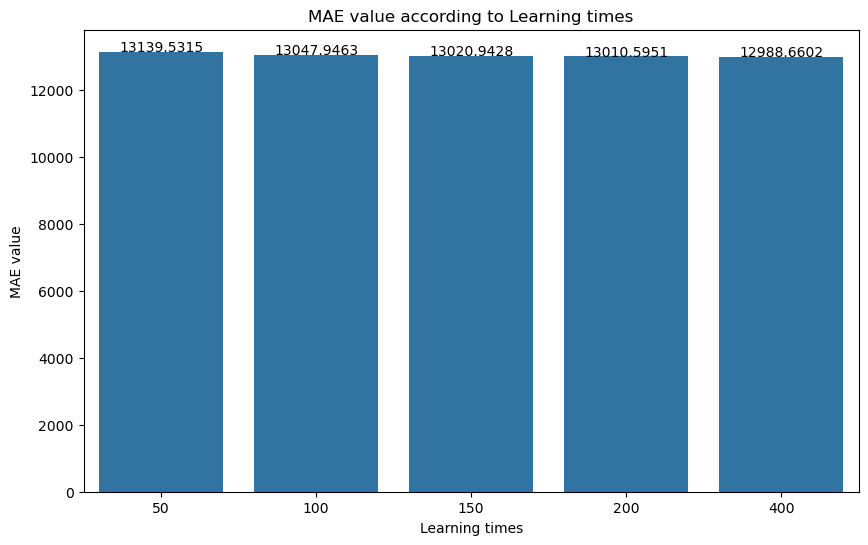

In [32]:
# 각 학습 횟수에 따른 MAE 시각화

plt.figure(figsize=(10, 6))
fig, ax = plt.subplots( figsize=(10,6) )

sns.barplot(x = learning_times, y = test_mae_list)

for p in ax.patches:
    ax.text(p.get_x() + (p.get_width()/2) ,   # 가로 위치
            p.get_y() + p.get_height(),   # 세로 위치
            f"{p.get_height():.4f}",     # 값 + 표시방법 소수 둘째자리까지 
            ha = 'center' )   # 좌우정렬 중간으로

plt.xlabel('Learning times')
plt.ylabel('MAE value')
plt.title('MAE value according to Learning times')
plt.show()

<Figure size 1000x600 with 0 Axes>

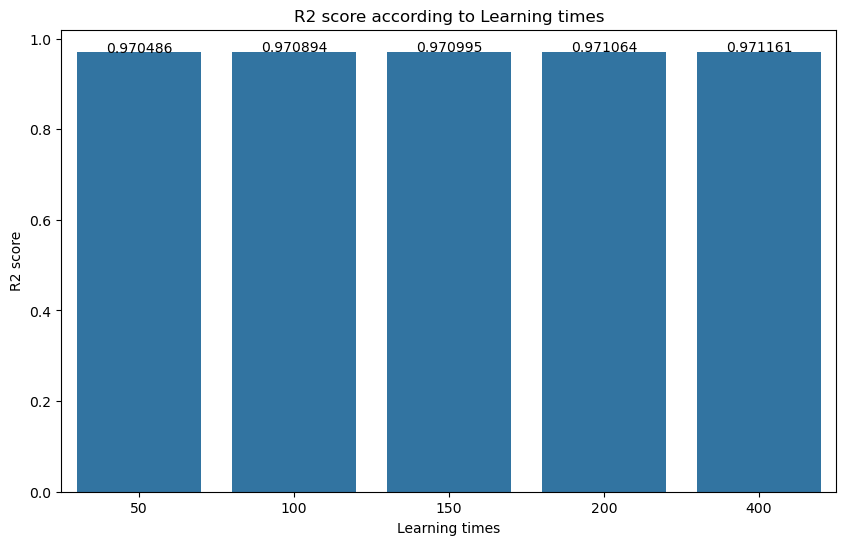

In [33]:
# 각 학습 횟수에 따른 R2 score 시각화

plt.figure(figsize=(10, 6))
fig, ax = plt.subplots( figsize=(10,6) )

sns.barplot(x = learning_times, y = test_r2_list)

for p in ax.patches:
    ax.text(p.get_x() + (p.get_width()/2) ,   # 가로 위치
            p.get_y() + p.get_height(),   # 세로 위치
            f"{p.get_height():.6f}",     # 값 + 표시방법 소수 둘째자리까지 
            ha = 'center' )   # 좌우정렬 중간으로

plt.xlabel('Learning times')
plt.ylabel('R2 score')
plt.title('R2 score according to Learning times')
plt.show()

### 결과

- 학습량이 많아질수록 MAE값이 작아지는 경향을 확인
- 모든 R2 score가 99.97%를 넘기며 학습량이 많아 질수록 R2 score가 미묘하게 상승하는 모습을 확인
- 단 price를 활용한 피쳐를 삭제하기 전보다는 선능, 정확도가 떨어지는 모습을 보임

- > 즉, 학습 횟수가 많아 질수록 성능 지표가 높아질 것으로 판단하고\
학습 횟수를 500부터 1000회까지 100회단위로 나누어 진행하고 그 결과를 시각화 하여 확인

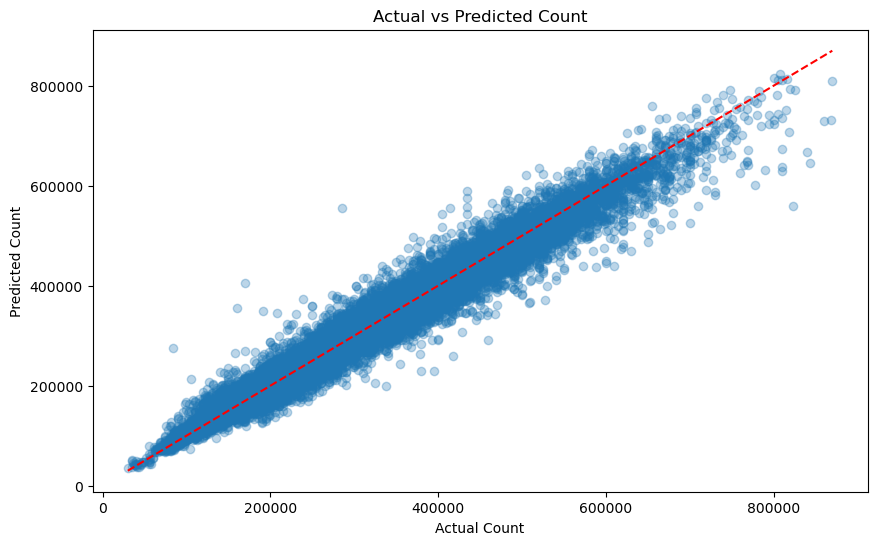

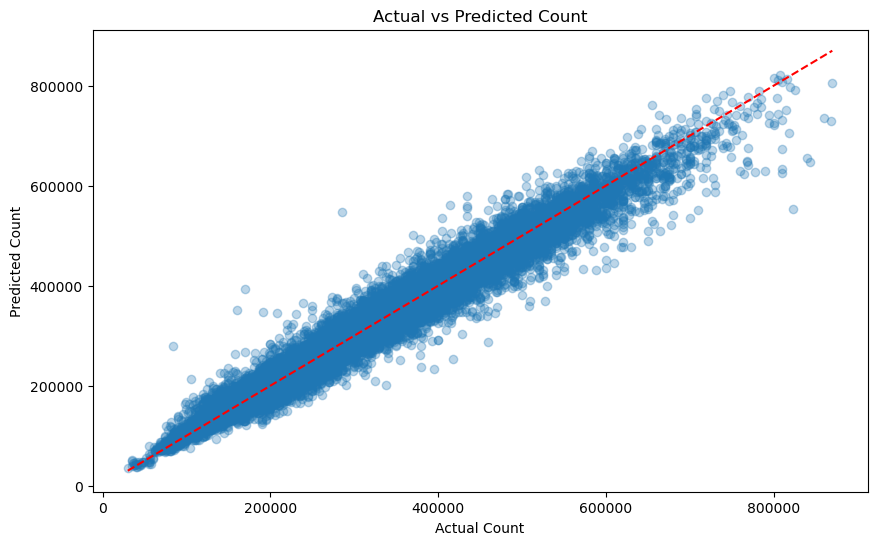

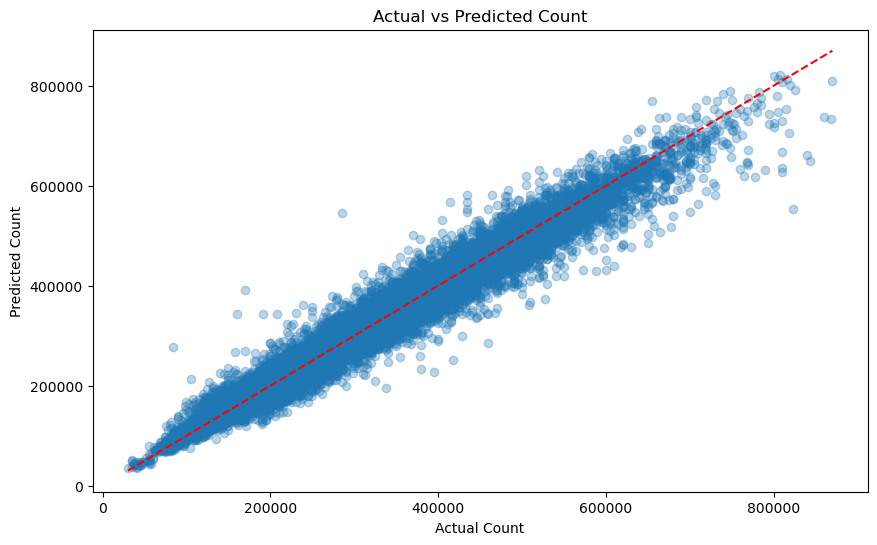

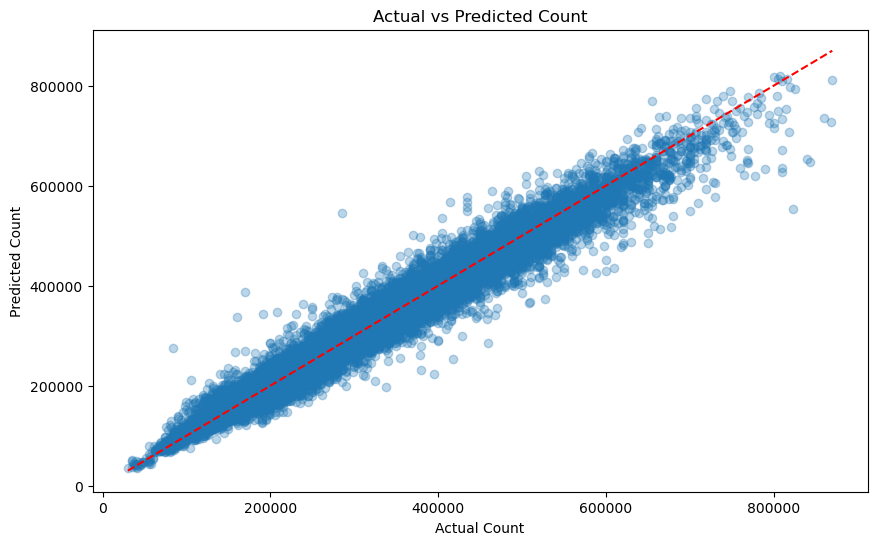

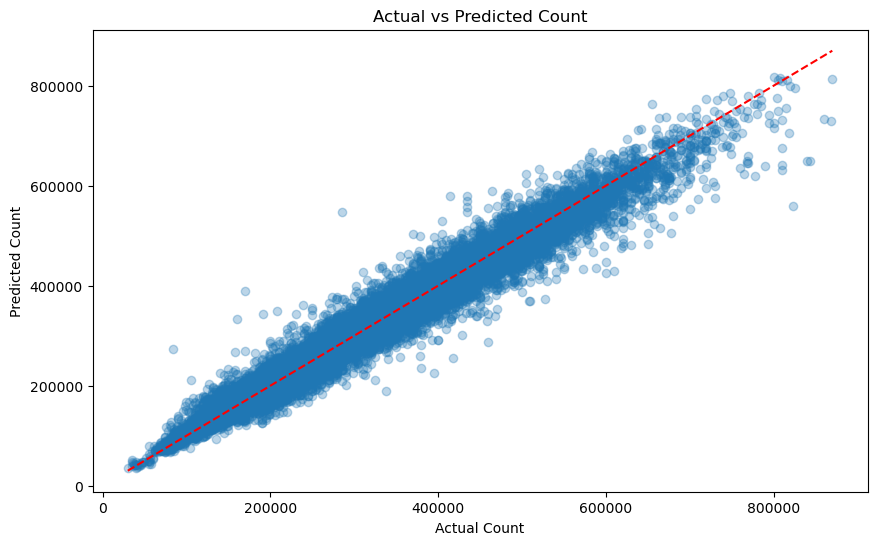

In [64]:
# 학습 횟수에 따른 각 결과 시각화
for y_pred_test in y_pred_test_list:
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred_test, alpha=0.3)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Actual Count')
    plt.ylabel('Predicted Count')
    plt.title('Actual vs Predicted Count')
    plt.show()

### Hyperparameter tuning

- 학습횟수를 500부터 1000회까지 100회단위로 나누어 추가 학습

In [38]:
# pc 리소스 부족으로 실행 오류
for learning_time in range(500, 1001, 100):
    learning_times.append(learning_time)

    model = RandomForestRegressor(
        n_estimators= learning_time,
        random_state=42
    )

    model.fit(X_train, y_train)

    learned_models.append(model)

    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    train_mae = mean_absolute_error(y_train, y_pred_train)
    test_mae = mean_absolute_error(y_test, y_pred_test)
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)

    y_pred_train_list.append(y_pred_train)
    y_pred_test_list.append(y_pred_test)

    train_mae_list.append(train_mae)
    test_mae_list.append(test_mae)
    train_r2_list.append(train_r2)
    test_r2_list.append(test_r2)

    print(learning_time + 'times done')
    print(f'Train MAE: {train_mae}, Train R^2: {train_r2}')
    print(f'Test MAE: {test_mae}, Test R^2: {test_r2}')

RandomForestRegressor(n_estimators=500, random_state=42)
Train MAE: 4807.846416711045, Train R^2: 0.995988687914482
Test MAE: 12984.6665333153, Test R^2: 0.9711801886398109
RandomForestRegressor(n_estimators=600, random_state=42)
Train MAE: 4806.635281977005, Train R^2: 0.995989390439945
Test MAE: 12985.995202053546, Test R^2: 0.9711738769543593
RandomForestRegressor(n_estimators=700, random_state=42)
Train MAE: 4804.605099820324, Train R^2: 0.9959949255551063
Test MAE: 12983.211339832553, Test R^2: 0.9711824446647047


In [67]:
# 각 학습 횟수별로 학습을 진행 후 학습 모델을 learning_models에 저장
# 메모리 사용량 문제로 사용 불가능
for learning_time in range(500, 1001, 100):
    model = RandomForestRegressor(
        n_estimators= learning_time,
        random_state=42
    )

    model.fit(X_train, y_train)

    learned_models.append(model)

    print(str(learning_time) + 'times done')

600times done
700times done


MemoryError: could not allocate 14680064 bytes

In [72]:
gc.collect()

6655

In [2]:
model = RandomForestRegressor(
        n_estimators= 500,
        random_state=42
    )

model.fit(X_train, y_train)

learned_models.append(model)

NameError: name 'RandomForestRegressor' is not defined

In [50]:
model = RandomForestRegressor(
        n_estimators= 600,
        random_state=42
    )

model.fit(X_train, y_train)

learned_models.append(model)

In [51]:
model = RandomForestRegressor(
        n_estimators= 700,
        random_state=42
    )

model.fit(X_train, y_train)

learned_models.append(model)

In [54]:
model = RandomForestRegressor(
        n_estimators= 800,
        random_state=42
    )

model.fit(X_train, y_train)

learned_models.append(model)

In [ ]:
model = RandomForestRegressor(
        n_estimators= 900,
        random_state=42
    )

model.fit(X_train, y_train)

learned_models.append(model)

In [ ]:
model = RandomForestRegressor(
        n_estimators= 1000,
        random_state=42
    )

model.fit(X_train, y_train)

learned_models.append(model)

In [1]:
learned_models[:]

NameError: name 'learned_models' is not defined

In [77]:
for model in learned_models[5]:
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    train_mae = mean_absolute_error(y_train, y_pred_train)
    test_mae = mean_absolute_error(y_test, y_pred_test)
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)

    y_pred_train_list.append(y_pred_train)
    y_pred_test_list.append(y_pred_test)

    train_mae_list.append(train_mae)
    test_mae_list.append(test_mae)
    train_r2_list.append(train_r2)
    test_r2_list.append(test_r2)

c:\Users\CHOI Je Woo\anaconda3\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Users\CHOI Je Woo\anaconda3\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Users\CHOI Je Woo\anaconda3\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Users\CHOI Je Woo\anaconda3\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Users\CHOI Je Woo\anaconda3\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Users\CHOI Je Woo\anaconda3\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature nam

MemoryError: Unable to allocate 11.6 MiB for an array with shape (217376, 14) and data type float32

In [75]:
learning_times = [50, 100, 150, 200, 400, 500, 600, 700, 800]

ValueError: All arrays must be of the same length

<Figure size 1600x600 with 0 Axes>

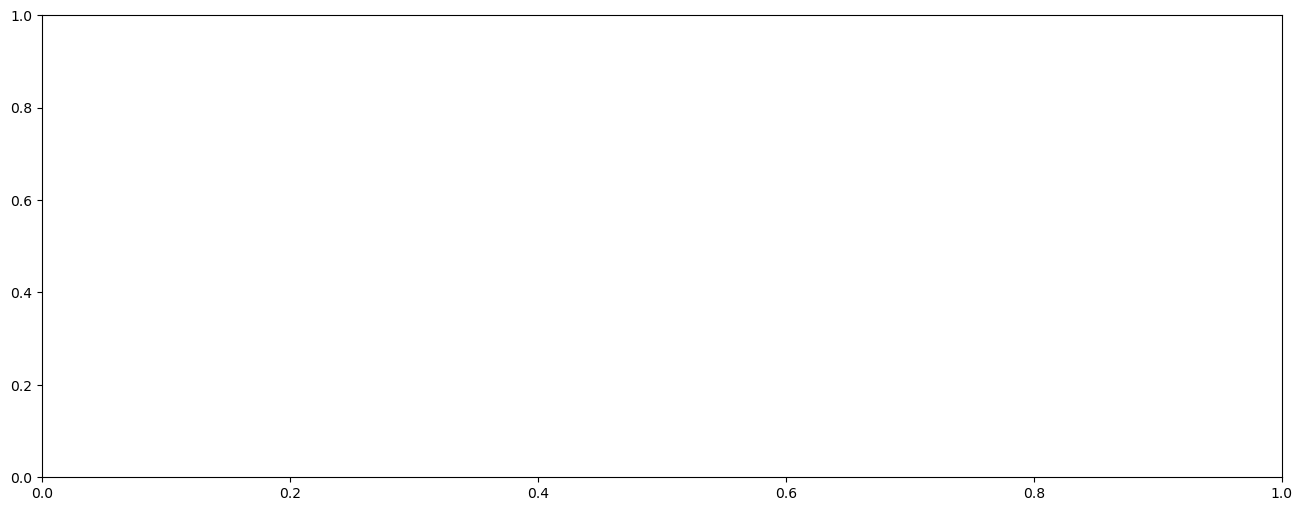

In [76]:
# 각 학습 횟수에 따른 MAE 시각화

plt.figure(figsize=(16, 6))
fig, ax = plt.subplots( figsize=(16,6) )

sns.barplot(x = learning_times, y = test_mae_list)

for p in ax.patches:
    ax.text(p.get_x() + (p.get_width()/2) ,   # 가로 위치
            p.get_y() + p.get_height(),   # 세로 위치
            f"{p.get_height():.4f}",     # 값 + 표시방법 소수 넷째자리까지 
            ha = 'center' )   # 좌우정렬 중간으로

plt.xlabel('Learning times')
plt.ylabel('MAE value')
plt.title('MAE value according to Learning times')
plt.show()

<Figure size 1600x600 with 0 Axes>

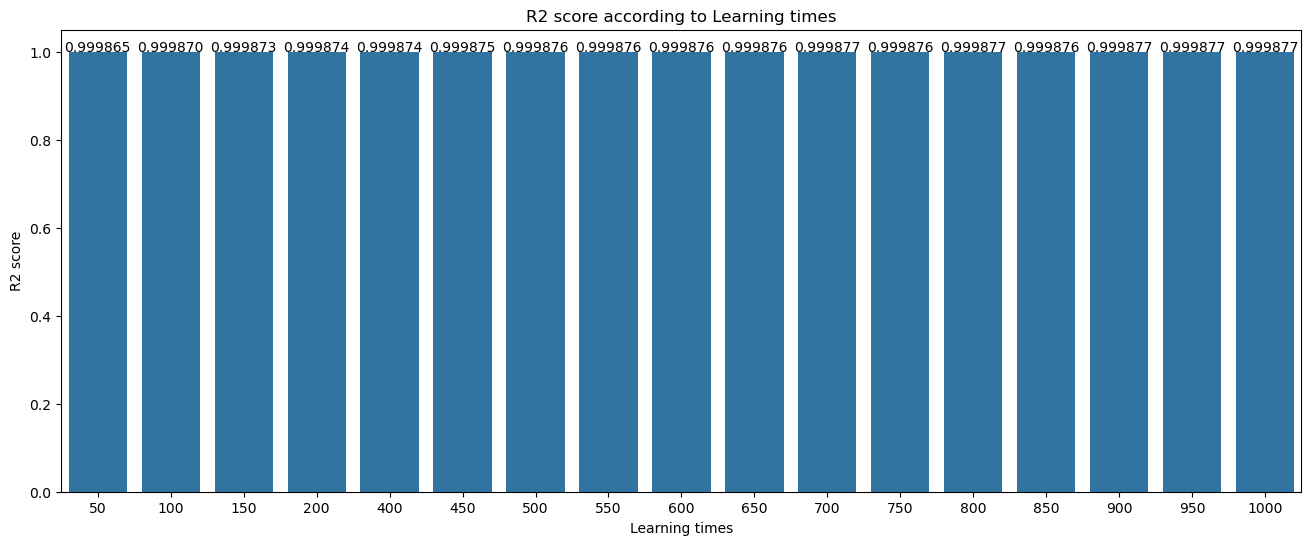

In [ ]:
# 각 학습 횟수에 따른 R2 score 시각화

plt.figure(figsize=(16, 6))
fig, ax = plt.subplots( figsize=(16,6) )

sns.barplot(x = learning_times, y = test_r2_list)

for p in ax.patches:
    ax.text(p.get_x() + (p.get_width()/2) ,   # 가로 위치
            p.get_y() + p.get_height(),   # 세로 위치
            f"{p.get_height():.6f}",     # 값 + 표시방법 소수 둘째자리까지 
            ha = 'center' )   # 좌우정렬 중간으로

plt.xlabel('Learning times')
plt.ylabel('R2 score')
plt.title('R2 score according to Learning times')
plt.show()

### 결론
- test data에 대해 모델의 학습 횟수가 증가할 수록 MAE값과 S2 score가 향상되는 양상을 보임
- 따라서 1000회의 학습 횟수로 학습을 진행한 마지막 모델을 사용하여 최종 테스트 모델을 학습

In [ ]:
# 지금까지의 과정을 csv파일로 저장
learning_times 
learned_models 
y_pred_train_list 
y_pred_test_list 
train_mae_list 
test_mae_list 
train_r2_list 
test_r2_list 

In [ ]:
df = pd.DataFrame({'learning_times' : learning_times,
                   'y_pred_train_list' : y_pred_train_list ,
                   'y_pred_test_list' : y_pred_test_list,
                   'train_mae_list' : train_mae_list,
                   'test_mae_list' : test_mae_list,
                   'train_r2_list' : train_r2_list,
                   'test_r2_list' : test_r2_list
                   })
df

,learning_times,y_pred_train_list,y_pred_test_list,train_mae_list,test_mae_list,train_r2_list,test_r2_list
0,50,"[145000.0, 389383.28, 271300.0, 317940.0, 2850...","[187910.0, 152000.0, 326980.0, 512639.78, 1959...",89.325707,213.580990,0.999968,0.999865
1,100,"[145000.0, 389440.52, 271350.0, 317970.0, 2850...","[187916.0, 152000.0, 326990.0, 512609.83, 1959...",82.820908,207.180746,0.999970,0.999870
2,150,"[145000.0, 389454.18666666665, 271270.0, 31798...","[187910.66666666666, 152000.0, 327000.0, 51271...",79.943028,203.389334,0.999972,0.999873
3,200,"[145000.0, 389442.02, 271297.5, 317985.0, 2850...","[187908.5, 152000.0, 327005.0, 512599.84, 1959...",78.924875,201.916272,0.999973,0.999874
4,400,"[145000.0, 389405.02, 271371.25, 317992.5, 285...","[187915.25, 152000.0, 326982.5, 512364.8275, 1...",76.934363,200.046770,0.999972,0.999874
5,450,"[145000.0, 389395.0755555556, 271394.444444444...","[187921.55555555556, 152000.0, 326980.0, 51240...",76.644635,199.894312,0.999972,0.999875
6,500,"[145000.0, 389388.896, 271393.0, 317993.0, 285...","[187918.4, 152000.0, 326986.0, 512433.81, 1959...",76.465098,199.500843,0.999973,0.999876
7,550,"[145000.0, 389388.0872727273, 271386.363636363...","[187922.18181818182, 152000.0, 326989.09090909...",76.319514,199.282392,0.999972,0.999876
8,600,"[145000.0, 389390.56, 271394.1666666667, 31799...","[187927.16666666666, 152000.0, 326988.33333333...",76.147394,199.119453,0.999973,0.999876
9,650,"[145000.0, 389395.9815384615, 271390.0, 317991...","[187926.61538461538, 152000.0, 326986.15384615...",76.089333,198.996457,0.999973,0.999876


In [ ]:
df.to_csv('./data/result_per_learningtimes_hyperparameter_type2.csv', index=False)

### 최종 학습
- 최종 테스트용 데이터를 학습

In [ ]:
data

,house_id,date,location,type,block,street,storey_range,area_sqm,flat_model,commence_date,type_num,area_per_room
0,2,2000-01,Austin,3 ROOM,174,Governors Row,04 TO 06,61.0,D,1986,3.0,20.333
1,5,2000-01,Austin,3 ROOM,218,Stonleigh Pl,07 TO 09,67.0,K,1976,3.0,22.333
2,22,2000-01,Austin,3 ROOM,443,Palisades Point Cove,07 TO 09,67.0,K,1979,3.0,22.333
3,23,2000-01,Austin,3 ROOM,443,Palisades Point Cove,07 TO 09,67.0,K,1979,3.0,22.333
4,28,2000-01,Austin,3 ROOM,435,Palisades Point Cove,04 TO 06,67.0,K,1979,3.0,22.333
...,...,...,...,...,...,...,...,...,...,...,...,...
67925,339632,2012-02,Riverside,4 ROOM,610,Northpark Dr,04 TO 06,84.0,N,1986,4.0,21.000
67926,339639,2012-02,Riverside,5 ROOM,796,Laredo Rd,04 TO 06,123.0,D,1987,5.0,24.600
67927,339642,2012-02,Riverside,5 ROOM,855,Laredo Rd,04 TO 06,127.0,D,1988,5.0,25.400
67928,339643,2012-02,Riverside,5 ROOM,366,Laredo Rd,07 TO 09,122.0,D,1988,5.0,24.400


In [ ]:
# 방의 타입에 따른 방개수 생성
# EXECUTIVE, MULTI-GENERATION는 결측치로 변경
tmp = []
for i in data['type']:
    if i == '5 ROOM':
        tmp.append(5)
    elif i == '4 ROOM':
        tmp.append(4)
    elif i == '3 ROOM':
        tmp.append(3)
    elif i == '2 ROOM':
        tmp.append(2)
    elif i == '1 ROOM':
        tmp.append(1)
    elif i == 'EXECUTIVE':
        tmp.append(None)
    else :
        tmp.append(None)
    
data['type_num'] = tmp


In [ ]:
# 결측치 확인
data['type_num'].isna().sum()

4941

In [ ]:
# 방개수 결측치 중앙값으로
tmp = []

tmp = data['type_num'].fillna(data['type_num'].median())
data['type_num'] = tmp
data['type_num']

0        3.0
1        3.0
2        3.0
3        3.0
4        3.0
        ... 
67925    4.0
67926    5.0
67927    5.0
67928    5.0
67929    5.0
Name: type_num, Length: 67930, dtype: float64

In [ ]:
# 방개수에 따른 방하나 평균 면적(m^2)
tmp = []
for num_rooms, area_sqm in zip(data['type_num'], data['area_sqm']):
    tmp.append(round(area_sqm/num_rooms, 3))
data['area_per_room'] = tmp

In [ ]:
# 단위면적(1m^2)당 가격
# tmp = []
# for price, area in zip(data['price'], data['area_sqm']):
#     tmp.append( round(price/area, 3) )
# data['price_per_unitarea'] = tmp

In [ ]:
# 방개수에 따른 방하나 평균 가격
# tmp = []
# for price, num_rooms in zip(data['price'], data['type_num']):
#     tmp.append( round(num_rooms/price, 3) )
# data['price_per_room'] = tmp

In [ ]:
# 지역과 블록을 합쳐 주소와 상세주소만 남긴다.
data['adress'] = data['location'] + '/' + data['block']
data.drop('location', axis=1, inplace=True)
data.drop('block', axis=1, inplace=True)
data

,house_id,date,type,street,storey_range,area_sqm,flat_model,commence_date,type_num,area_per_room,adress
0,2,2000-01,3 ROOM,Governors Row,04 TO 06,61.0,D,1986,3.0,20.333,Austin/174
1,5,2000-01,3 ROOM,Stonleigh Pl,07 TO 09,67.0,K,1976,3.0,22.333,Austin/218
2,22,2000-01,3 ROOM,Palisades Point Cove,07 TO 09,67.0,K,1979,3.0,22.333,Austin/443
3,23,2000-01,3 ROOM,Palisades Point Cove,07 TO 09,67.0,K,1979,3.0,22.333,Austin/443
4,28,2000-01,3 ROOM,Palisades Point Cove,04 TO 06,67.0,K,1979,3.0,22.333,Austin/435
...,...,...,...,...,...,...,...,...,...,...,...
67925,339632,2012-02,4 ROOM,Northpark Dr,04 TO 06,84.0,N,1986,4.0,21.000,Riverside/610
67926,339639,2012-02,5 ROOM,Laredo Rd,04 TO 06,123.0,D,1987,5.0,24.600,Riverside/796
67927,339642,2012-02,5 ROOM,Laredo Rd,04 TO 06,127.0,D,1988,5.0,25.400,Riverside/855
67928,339643,2012-02,5 ROOM,Laredo Rd,07 TO 09,122.0,D,1988,5.0,24.400,Riverside/366


In [ ]:
# 'date' 컬럼을 datetime 타입으로 변환하고, 연, 월 로 분리
tmp = {}
tmp['date'] = pd.to_datetime(data['date'])
data['Year'] = tmp['date'].dt.year
data['Month'] = tmp['date'].dt.month


In [ ]:
data.drop('date', axis=1, inplace=True)

In [ ]:
#팔리기까지의 기간
tmp_list = []

for i, j in zip(data['commence_date'], data['Year']):
    tmp_list.append(j-i)

data['time_to_sell'] = tmp_list

In [ ]:
#  2000~2012년의 미국 금리 데이터를 가져옴
interest_rate_df = pd.read_csv('./data/interest_rate.csv')
interest_rate_df

,interest_rate_date,interest_rate
0,2012-12-13,0.25
1,2012-10-25,0.25
2,2012-09-14,0.25
3,2012-08-02,0.25
4,2012-06-21,0.25
...,...,...
73,2001-02-01,5.50
74,2001-01-04,6.00
75,2000-05-17,6.50
76,2000-03-22,6.00


In [ ]:
# 날자 데이터를 비교하여 당일의 금리를 확인하여 저장

tmp = interest_rate_df['interest_rate'][77]
tmp_interest_rate = []

for year, month in zip(data['Year'], data['Month']):
    date = str(year) + '-' + str(month)
    # print(pd.Timestamp(date))
    
    for interest_date, interest_rate in zip(interest_rate_df['interest_rate_date'][::-1], interest_rate_df['interest_rate'][::-1]):
        if pd.Timestamp(date) < pd.Timestamp(interest_date):
            # 금리 갱신일 이 날자보다 커지면 그 이전 날의 금리(tmp)를 저장
            tmp_interest_rate.append(tmp)
            tmp = interest_rate_df['interest_rate'][77]
            break
        # 금리 갱신일이 당일 날자보다 낮다면 해당의 금리로 tmp를 갱신
        tmp = interest_rate

In [ ]:
# 생성한 리스트를 dataframe에 합침
data['interest_rate'] = tmp_interest_rate

In [ ]:
data

,house_id,type,street,storey_range,area_sqm,flat_model,commence_date,type_num,area_per_room,adress,Year,Month,time_to_sell,interest_rate
0,2,3 ROOM,Governors Row,04 TO 06,61.0,D,1986,3.0,20.333,Austin/174,2000,1,14,5.75
1,5,3 ROOM,Stonleigh Pl,07 TO 09,67.0,K,1976,3.0,22.333,Austin/218,2000,1,24,5.75
2,22,3 ROOM,Palisades Point Cove,07 TO 09,67.0,K,1979,3.0,22.333,Austin/443,2000,1,21,5.75
3,23,3 ROOM,Palisades Point Cove,07 TO 09,67.0,K,1979,3.0,22.333,Austin/443,2000,1,21,5.75
4,28,3 ROOM,Palisades Point Cove,04 TO 06,67.0,K,1979,3.0,22.333,Austin/435,2000,1,21,5.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67925,339632,4 ROOM,Northpark Dr,04 TO 06,84.0,N,1986,4.0,21.000,Riverside/610,2012,2,26,0.25
67926,339639,5 ROOM,Laredo Rd,04 TO 06,123.0,D,1987,5.0,24.600,Riverside/796,2012,2,25,0.25
67927,339642,5 ROOM,Laredo Rd,04 TO 06,127.0,D,1988,5.0,25.400,Riverside/855,2012,2,24,0.25
67928,339643,5 ROOM,Laredo Rd,07 TO 09,122.0,D,1988,5.0,24.400,Riverside/366,2012,2,24,0.25


In [ ]:
data

,house_id,type,street,storey_range,area_sqm,flat_model,commence_date,type_num,area_per_room,adress,Year,Month,time_to_sell,interest_rate
0,2,3 ROOM,Governors Row,04 TO 06,61.0,D,1986,3.0,20.333,Austin/174,2000,1,14,5.75
1,5,3 ROOM,Stonleigh Pl,07 TO 09,67.0,K,1976,3.0,22.333,Austin/218,2000,1,24,5.75
2,22,3 ROOM,Palisades Point Cove,07 TO 09,67.0,K,1979,3.0,22.333,Austin/443,2000,1,21,5.75
3,23,3 ROOM,Palisades Point Cove,07 TO 09,67.0,K,1979,3.0,22.333,Austin/443,2000,1,21,5.75
4,28,3 ROOM,Palisades Point Cove,04 TO 06,67.0,K,1979,3.0,22.333,Austin/435,2000,1,21,5.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67925,339632,4 ROOM,Northpark Dr,04 TO 06,84.0,N,1986,4.0,21.000,Riverside/610,2012,2,26,0.25
67926,339639,5 ROOM,Laredo Rd,04 TO 06,123.0,D,1987,5.0,24.600,Riverside/796,2012,2,25,0.25
67927,339642,5 ROOM,Laredo Rd,04 TO 06,127.0,D,1988,5.0,25.400,Riverside/855,2012,2,24,0.25
67928,339643,5 ROOM,Laredo Rd,07 TO 09,122.0,D,1988,5.0,24.400,Riverside/366,2012,2,24,0.25


In [ ]:
#정규화
categorical_features = ['type', 'street', 'storey_range', 'flat_model', 'commence_date', 'adress', 'Year', 'Month']

le = LabelEncoder()
for i in categorical_features:
    data[i] = le.fit_transform(data[i])

In [ ]:
numerical_features = ['area_sqm', 'time_to_sell', 'type_num', 'area_per_room', 'interest_rate']

scaler = MinMaxScaler()
data[numerical_features] = scaler.fit_transform(data[numerical_features])

In [ ]:
data

,house_id,type,street,storey_range,area_sqm,flat_model,commence_date,type_num,area_per_room,adress,Year,Month,time_to_sell,interest_rate
0,2,2,180,1,0.135021,3,20,0.50,0.055299,899,0,0,0.340426,0.88
1,5,2,429,2,0.160338,10,10,0.50,0.082949,922,0,0,0.553191,0.88
2,22,2,323,2,0.160338,10,13,0.50,0.082949,1030,0,0,0.489362,0.88
3,23,2,323,2,0.160338,10,13,0.50,0.082949,1030,0,0,0.489362,0.88
4,28,2,323,1,0.160338,10,13,0.50,0.082949,1022,0,0,0.489362,0.88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67925,339632,3,299,1,0.232068,13,20,0.75,0.064520,5710,12,1,0.595745,0.00
67926,339639,4,224,1,0.396624,3,21,1.00,0.114289,5858,12,1,0.574468,0.00
67927,339642,4,224,1,0.413502,3,22,1.00,0.125349,5906,12,1,0.553191,0.00
67928,339643,4,224,2,0.392405,3,22,1.00,0.111524,5662,12,1,0.553191,0.00


In [ ]:
data_test_model = learned_models[-1]

In [ ]:
data_pred = data_test_model.predict(data)
y_pred_test = model.predict(X_test)

ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- price_per_room
- price_per_unitarea


### 오류 발견

- 실제 데이터에는 학습당시 알수 있던 피쳐를 넣어줄수 없음
    - `price_per_unitarea` - 단위면적(1m^2)당 가격
    - `price_per_room` - 방하나당 평균 가격

-> 피처 엔지니어링 및 학습을 다시진행